<a href="https://colab.research.google.com/github/danimacaya/AIInternational/blob/main/AI_international.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports/setup
import os, re, random
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

Mounted at /content/drive


In [2]:
# Load Google Drive data/set paths

DATA_ROOT = "/content/drive/MyDrive/Assignment_25_26"
#os.chdir(DATA_ROOT)
META_PATH = os.path.join(DATA_ROOT, "training_metadata.xlsx")
IMAGES_DIR = os.path.join(DATA_ROOT, "training_images")


In [3]:
## Load data to pandas

df = pd.read_excel(META_PATH)

# Normalize column names (tolerant to 'Mask' vs 'MASK', etc.)
df.columns = [c.strip().upper() for c in df.columns]
required = {"US", "MASK", "LABEL"}
missing_cols = required - set(df.columns)
assert not missing_cols, f"Missing columns in Excel: {missing_cols}"

# Basic cleanup
df["US"] = df["US"].astype(str).str.strip()
df["MASK"] = df["MASK"].astype(str).str.strip()
df["LABEL"] = df["LABEL"].astype(int)

# Patient ID = leading digits before underscore (works for '233_1.png' and '943.png')
def patient_id_from_us(filename: str) -> int:
    m = re.match(r"^(\d+)", filename)
    if not m:
        raise ValueError(f"Cannot parse patient id from US filename: {filename}")
    return int(m.group(1))

df["PATIENT_ID"] = df["US"].apply(patient_id_from_us)

# Full paths
df["US_PATH"] = df["US"].apply(lambda x: os.path.join(IMAGES_DIR, x))
df["MASK_PATH"] = df["MASK"].apply(lambda x: os.path.join(IMAGES_DIR, x))

df.head()


,US,MASK,LABEL,PATIENT_ID,US_PATH,MASK_PATH
0,1.png,1_mask.png,2,1,/content/drive/MyDrive/Assignment_25_26/traini...,/content/drive/MyDrive/Assignment_25_26/traini...
1,2.png,2_mask.png,2,2,/content/drive/MyDrive/Assignment_25_26/traini...,/content/drive/MyDrive/Assignment_25_26/traini...
2,3.png,3_mask.png,2,3,/content/drive/MyDrive/Assignment_25_26/traini...,/content/drive/MyDrive/Assignment_25_26/traini...
3,4.png,4_mask.png,2,4,/content/drive/MyDrive/Assignment_25_26/traini...,/content/drive/MyDrive/Assignment_25_26/traini...
4,5.png,5_mask.png,2,5,/content/drive/MyDrive/Assignment_25_26/traini...,/content/drive/MyDrive/Assignment_25_26/traini...


In [4]:
## Check missing/audit data
missing_us = df[~df["US_PATH"].map(os.path.exists)]
missing_mask = df[~df["MASK_PATH"].map(os.path.exists)]

print("Rows:", len(df))
print("Unique patients:", df["PATIENT_ID"].nunique())
print("\nLabel distribution (row-level):")
print(df["LABEL"].value_counts().sort_index())

print("\nMissing US files:", len(missing_us))
print("Missing MASK files:", len(missing_mask))

assert len(missing_us) == 0, "Some US files are missing. Inspect missing_us."
assert len(missing_mask) == 0, "Some MASK files are missing. Inspect missing_mask."


Rows: 1503
Unique patients: 968

Label distribution (row-level):
LABEL
0    679
1    364
2    460
Name: count, dtype: int64

Missing US files: 0
Missing MASK files: 0


In [5]:
def audit_dataset(df, sample_n=None):
    rows = df if sample_n is None else df.sample(sample_n, random_state=SEED)

    bad_shape = []
    bad_mask_values = []
    normal_with_nonzero_mask = []
    lesion_with_empty_mask = []

    sizes = []
    modes = {"US": {}, "MASK": {}}

    for _, r in tqdm(rows.iterrows(), total=len(rows)):
        us = Image.open(r["US_PATH"])
        mk = Image.open(r["MASK_PATH"])

        # record sizes/modes
        sizes.append((us.size[1], us.size[0]))  # (H,W)
        modes["US"][us.mode] = modes["US"].get(us.mode, 0) + 1
        modes["MASK"][mk.mode] = modes["MASK"].get(mk.mode, 0) + 1

        if us.size != mk.size:
            bad_shape.append((r["US"], r["MASK"], us.size, mk.size))
            continue

        mk_arr = np.array(mk)
        uniq = np.unique(mk_arr)
        if not set(uniq.tolist()).issubset({0, 255}):
            bad_mask_values.append((r["MASK"], uniq[:10]))

        mk_has_lesion = (mk_arr > 0).any()

        if r["LABEL"] == 2 and mk_has_lesion:
            normal_with_nonzero_mask.append(r["US"])
        if r["LABEL"] in (0, 1) and (not mk_has_lesion):
            lesion_with_empty_mask.append(r["US"])

    # size stats
    hs = np.array([h for h, w in sizes])
    ws = np.array([w for h, w in sizes])
    def pct(a, p): return int(np.percentile(a, p))

    print("\n--- Deep audit summary ---")
    print("US modes:", modes["US"])
    print("MASK modes:", modes["MASK"])
    print("Size percentiles H (px):", {p: pct(hs, p) for p in [0,10,50,90,100]})
    print("Size percentiles W (px):", {p: pct(ws, p) for p in [0,10,50,90,100]})

    print("\nAlignment mismatches:", len(bad_shape))
    print("Non-binary masks:", len(bad_mask_values))
    print("Normal label but non-zero mask:", len(normal_with_nonzero_mask))
    print("Benign/Malignant label but empty mask:", len(lesion_with_empty_mask))

    return {
        "bad_shape": bad_shape,
        "bad_mask_values": bad_mask_values,
        "normal_with_nonzero_mask": normal_with_nonzero_mask,
        "lesion_with_empty_mask": lesion_with_empty_mask
    }

audit_issues = audit_dataset(df, sample_n=10)  # set sample_n=300 if you want faster first pass, otherwise >13min


100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


--- Deep audit summary ---
US modes: {'RGB': 8, 'RGBA': 2}
MASK modes: {'RGB': 1, 'L': 9}
Size percentiles H (px): {0: 462, 10: 470, 50: 571, 90: 606, 100: 606}
Size percentiles W (px): {0: 545, 10: 562, 50: 748, 90: 856, 100: 856}

Alignment mismatches: 0
Non-binary masks: 0
Normal label but non-zero mask: 0
Benign/Malignant label but empty mask: 0


In [6]:
def patient_stratified_split(df, val_frac=0.15, test_frac=0.15, seed=42):
    # patient -> majority label (fallback for stratification)
    p_lbl = df.groupby("PATIENT_ID")["LABEL"].agg(lambda s: s.value_counts().idxmax())

    patients = p_lbl.index.to_numpy()
    labels = p_lbl.to_numpy()

    rng = np.random.default_rng(seed)

    train_p, val_p, test_p = [], [], []
    for cls in sorted(np.unique(labels)):
        cls_patients = patients[labels == cls]
        rng.shuffle(cls_patients)

        n = len(cls_patients)
        n_test = int(round(test_frac * n))
        n_val = int(round(val_frac * n))

        test_p.extend(cls_patients[:n_test])
        val_p.extend(cls_patients[n_test:n_test+n_val])
        train_p.extend(cls_patients[n_test+n_val:])

    train_p, val_p, test_p = map(np.array, (train_p, val_p, test_p))

    train_df = df[df["PATIENT_ID"].isin(train_p)].reset_index(drop=True)
    val_df   = df[df["PATIENT_ID"].isin(val_p)].reset_index(drop=True)
    test_df  = df[df["PATIENT_ID"].isin(test_p)].reset_index(drop=True)

    return train_df, val_df, test_df

train_df, val_df, test_df = patient_stratified_split(df)

print(len(train_df), len(val_df), len(test_df))
print("Patient overlap train/val:", set(train_df.PATIENT_ID) & set(val_df.PATIENT_ID))
print("Patient overlap train/test:", set(train_df.PATIENT_ID) & set(test_df.PATIENT_ID))
print("\nTrain label dist:", train_df["LABEL"].value_counts().sort_index().to_dict())
print("Val   label dist:", val_df["LABEL"].value_counts().sort_index().to_dict())
print("Test  label dist:", test_df["LABEL"].value_counts().sort_index().to_dict())


1108 183 212
Patient overlap train/val: set()
Patient overlap train/test: set()

Train label dist: {0: 506, 1: 251, 2: 351}
Val   label dist: {0: 86, 1: 50, 2: 47}
Test  label dist: {0: 87, 1: 63, 2: 62}


In [7]:
from torchvision.transforms import functional as TF
from torchvision.transforms.functional import InterpolationMode

def pad_to_square_pil(im: Image.Image, fill=0):
    w, h = im.size
    if w == h:
        return im
    # padding: left, top, right, bottom
    if w > h:
        pad = (0, (w - h)//2, 0, (w - h) - (w - h)//2)
    else:
        pad = ((h - w)//2, 0, (h - w) - (h - w)//2, 0)
    return TF.pad(im, pad, fill=fill)

def preprocess_us_image(path, out_size=256):
    """
    Returns: torch.FloatTensor [1, out_size, out_size]
    Steps: RGB->grayscale, pad-to-square, resize, [0,1], per-image z-score
    """
    im = Image.open(path)
    im = ImageOps.grayscale(im)               # 1-channel
    im = pad_to_square_pil(im, fill=0)
    im = TF.resize(im, (out_size, out_size), interpolation=InterpolationMode.BILINEAR)
    x = TF.to_tensor(im)                      # [1,H,W] float in [0,1]
    mean = x.mean()
    std = x.std().clamp_min(1e-6)
    x = (x - mean) / std
    return x

def preprocess_mask_binary(path, out_size=256):
    """
    Returns: torch.FloatTensor [1, out_size, out_size] in {0,1}
    Steps: load, binarize >0, pad-to-square, resize NEAREST
    """
    mk = Image.open(path)
    mk = ImageOps.grayscale(mk)
    mk_arr = (np.array(mk) > 0).astype(np.uint8) * 255
    mk = Image.fromarray(mk_arr, mode="L")
    mk = pad_to_square_pil(mk, fill=0)
    mk = TF.resize(mk, (out_size, out_size), interpolation=InterpolationMode.NEAREST)
    y = TF.to_tensor(mk)                      # [1,H,W] in {0,1} (since 0/255)
    y = (y > 0.5).float()
    return y


/tmp/ipython-input-2507514106.py:38: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mk = Image.fromarray(mk_arr, mode="L")


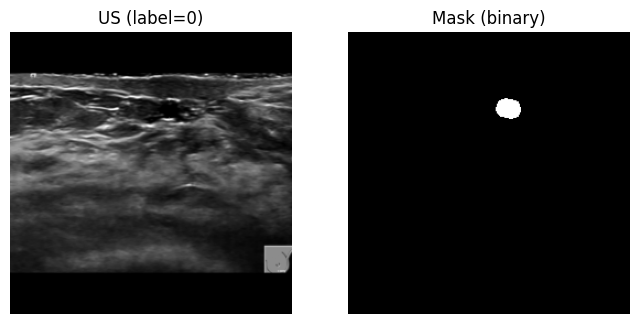

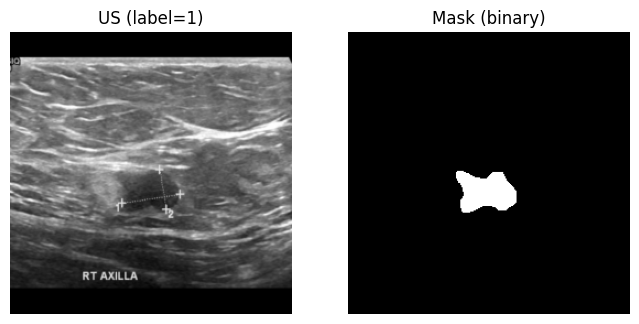

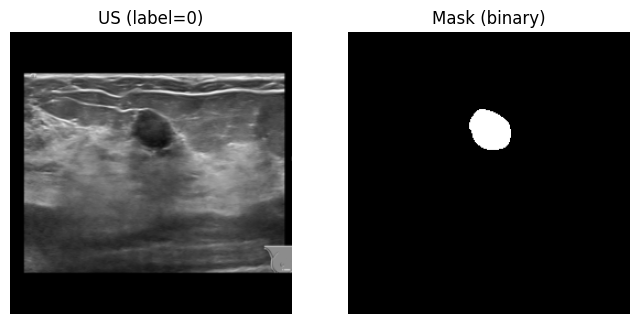

In [8]:
import matplotlib.pyplot as plt

def show_sample(row, out_size=256):
    x = preprocess_us_image(row["US_PATH"], out_size=out_size)
    y = preprocess_mask_binary(row["MASK_PATH"], out_size=out_size)
    lbl = row["LABEL"]

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(x[0].numpy(), cmap="gray")
    ax[0].set_title(f"US (label={lbl})")
    ax[0].axis("off")

    ax[1].imshow(y[0].numpy(), cmap="gray")
    ax[1].set_title("Mask (binary)")
    ax[1].axis("off")
    plt.show()

# show 3 random samples
for i in np.random.default_rng(SEED).choice(len(train_df), size=3, replace=False):
    show_sample(train_df.loc[i], out_size=256)


In [9]:

def load_us_pil(path: str) -> Image.Image:
    im = Image.open(path)
    im = ImageOps.grayscale(im)  # consistent 1-channel
    return im

def load_mask_pil_binary(path: str) -> Image.Image:
    mk = Image.open(path)
    mk = ImageOps.grayscale(mk)
    arr = (np.array(mk) > 0).astype(np.uint8) * 255
    return Image.fromarray(arr).convert("L")

def preprocess_to_square_resized_pil(im: Image.Image, out_size=256, is_mask=False) -> Image.Image:
    im = pad_to_square_pil(im, fill=0)
    interp = InterpolationMode.NEAREST if is_mask else InterpolationMode.BILINEAR
    im = TF.resize(im, (out_size, out_size), interpolation=interp)
    return im

# ---- Paired geometric augmentation (same transform to image & mask) ----
class PairedRandomAffine:
    def __init__(self, degrees=12, translate=0.05, scale=(0.9, 1.1), p=0.8):
        self.degrees = degrees
        self.translate = translate
        self.scale = scale
        self.p = p

    def __call__(self, img_pil: Image.Image, mask_pil: Image.Image | None):
        if torch.rand(1).item() > self.p:
            return img_pil, mask_pil

        angle = (torch.rand(1).item() * 2 - 1) * self.degrees
        max_dx = self.translate * img_pil.size[0]
        max_dy = self.translate * img_pil.size[1]
        tx = int((torch.rand(1).item() * 2 - 1) * max_dx)
        ty = int((torch.rand(1).item() * 2 - 1) * max_dy)
        sc = self.scale[0] + torch.rand(1).item() * (self.scale[1] - self.scale[0])

        img_pil = TF.affine(
            img_pil, angle=angle, translate=[tx, ty], scale=sc, shear=[0.0, 0.0],
            interpolation=InterpolationMode.BILINEAR, fill=0
        )
        if mask_pil is not None:
            mask_pil = TF.affine(
                mask_pil, angle=angle, translate=[tx, ty], scale=sc, shear=[0.0, 0.0],
                interpolation=InterpolationMode.NEAREST, fill=0
            )
        return img_pil, mask_pil

class PairedRandomHFlip:
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, img_pil: Image.Image, mask_pil: Image.Image | None):
        if torch.rand(1).item() < self.p:
            img_pil = TF.hflip(img_pil)
            if mask_pil is not None:
                mask_pil = TF.hflip(mask_pil)
        return img_pil, mask_pil

# ---- Image-only intensity augmentation ----
class RandomBrightnessContrast:
    def __init__(self, brightness=0.12, contrast=0.12, p=0.7):
        self.brightness = brightness
        self.contrast = contrast
        self.p = p
    def __call__(self, img_pil: Image.Image):
        if torch.rand(1).item() > self.p:
            return img_pil
        # brightness factor in [1-b, 1+b]
        b = 1.0 + (torch.rand(1).item() * 2 - 1) * self.brightness
        c = 1.0 + (torch.rand(1).item() * 2 - 1) * self.contrast
        img_pil = TF.adjust_brightness(img_pil, b)
        img_pil = TF.adjust_contrast(img_pil, c)
        return img_pil

# ---- Tensor-level noise ----
class AddGaussianNoise:
    def __init__(self, sigma=0.05, p=0.4):
        self.sigma = sigma
        self.p = p
    def __call__(self, x: torch.Tensor):
        if torch.rand(1).item() > self.p:
            return x
        return x + torch.randn_like(x) * self.sigma


In [10]:
from torch.utils.data import Dataset

class BreastUSDataset(Dataset):
    """
    task:
      - "classification": returns (x, y)
      - "cls_masked_bm": returns (x_masked, y_bm)   # y_bm: 0=benign, 1=malignant
      - "seg_binary": returns (x, mask_binary, y)
      - "seg_3class": returns (x, mask_3class_long, y)
        where mask classes: 0=background, 1=benign lesion, 2=malignant lesion
    """
    def __init__(self, df, out_size=256, task="classification", is_train=False, augment=False):
        self.df = df.reset_index(drop=True)
        self.out_size = out_size
        self.task = task
        self.is_train = is_train
        self.augment = augment and is_train

        # paired geometric transforms (apply to img+mask together)
        self.paired_aug = [
            PairedRandomHFlip(p=0.5),
            PairedRandomAffine(degrees=12, translate=0.05, scale=(0.9, 1.1), p=0.8),
        ]
        # image-only intensity aug
        self.intensity_aug = RandomBrightnessContrast(brightness=0.12, contrast=0.12, p=0.7)
        # tensor noise
        self.noise_aug = AddGaussianNoise(sigma=0.05, p=0.4)

    def __len__(self):
        return len(self.df)

    def _to_tensor_and_normalize(self, img_pil: Image.Image) -> torch.Tensor:
        x = TF.to_tensor(img_pil)  # [1,H,W] in [0,1]
        mean = x.mean()
        std = x.std().clamp_min(1e-6)
        x = (x - mean) / std
        if self.augment:
            x = self.noise_aug(x)
        return x

    def __getitem__(self, idx):
        r = self.df.loc[idx]
        y = int(r["LABEL"])

        # Load PIL
        img = load_us_pil(r["US_PATH"])
        mask = None
        if self.task in ("seg_binary", "seg_3class", "cls_masked_bm"):
          mask = load_mask_pil_binary(r["MASK_PATH"])

        # Preprocess to square + resize
        img = preprocess_to_square_resized_pil(img, out_size=self.out_size, is_mask=False)
        if mask is not None:
            mask = preprocess_to_square_resized_pil(mask, out_size=self.out_size, is_mask=True)

        # Augment (train only)
        if self.augment:
            # intensity first (image only)
            img = self.intensity_aug(img)
            # paired geom (image + mask)
            for t in self.paired_aug:
                img, mask = t(img, mask)

        # To tensor
        x = self._to_tensor_and_normalize(img)

        if self.task == "classification":
            return x, y

        # mask tensor (only for tasks that loaded a mask)
        m = None
        if mask is not None:
            m = TF.to_tensor(mask)      # [1,H,W], typically 0 or 1
            m = (m > 0.5).float()

        # ---- masked-image classification (Benign vs Malignant) ----
        if self.task == "cls_masked_bm":
            if y == 2:
                raise ValueError("cls_masked_bm expects only B/M samples. Filter df to LABEL in {0,1}.")
            y_bm = 0 if y == 0 else 1   # benign->0, malignant->1
            x_masked = x * m            # suppress background
            return x_masked, y_bm

        if self.task == "seg_binary":
            return x, m, y

        if self.task == "seg_3class":
            # Convert binary lesion mask to 3-class map using image-level label:
            # Normal (2): all background
            # Benign (0): lesion pixels -> 1
            # Malignant (1): lesion pixels -> 2
            m_hw = m[0]  # [H,W]
            if y == 2:
                m3 = torch.zeros_like(m_hw, dtype=torch.long)
            elif y == 0:
                m3 = (m_hw > 0.5).long() * 1
            elif y == 1:
                m3 = (m_hw > 0.5).long() * 2
            else:
                raise ValueError(f"Unexpected label: {y}")
            return x, m3, y

        raise ValueError(f"Unknown task: {self.task}")


In [11]:
from torch.utils.data import DataLoader

def seed_worker(worker_id):
    # makes augmentation randomness reproducible across workers
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    torch.manual_seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)

# --- classification loaders ---
train_cls_ds = BreastUSDataset(train_df, out_size=256, task="classification", is_train=True, augment=True)
val_cls_ds   = BreastUSDataset(val_df,   out_size=256, task="classification", is_train=False, augment=False)
test_cls_ds  = BreastUSDataset(test_df,  out_size=256, task="classification", is_train=False, augment=False)

train_cls_loader = DataLoader(train_cls_ds, batch_size=32, shuffle=True, num_workers=2,
                              pin_memory=True, worker_init_fn=seed_worker, generator=g)
val_cls_loader   = DataLoader(val_cls_ds, batch_size=32, shuffle=False, num_workers=2,
                              pin_memory=True, worker_init_fn=seed_worker, generator=g)

# --- segmentation loaders (binary lesion) ---  (B/M only per spec)
train_df_bm = train_df[train_df["LABEL"].isin([0, 1])].reset_index(drop=True)
val_df_bm   = val_df[val_df["LABEL"].isin([0, 1])].reset_index(drop=True)
test_df_bm = test_df[test_df["LABEL"].isin([0, 1])].reset_index(drop=True) # Moved definition here

train_seg_ds = BreastUSDataset(train_df_bm, out_size=256, task="seg_binary", is_train=True, augment=True)
val_seg_ds   = BreastUSDataset(val_df_bm,   out_size=256, task="seg_binary", is_train=False, augment=False)


train_seg_loader = DataLoader(train_seg_ds, batch_size=16, shuffle=True, num_workers=2,
                              pin_memory=True, worker_init_fn=seed_worker, generator=g)
val_seg_loader   = DataLoader(val_seg_ds, batch_size=16, shuffle=False, num_workers=2,
                              pin_memory=True, worker_init_fn=seed_worker, generator=g)
print("train_df_bm label counts:", train_df_bm["LABEL"].value_counts().sort_index().to_dict())
print("val_df_bm   label counts:", val_df_bm["LABEL"].value_counts().sort_index().to_dict())
print("test_df_bm  label counts:", test_df_bm["LABEL"].value_counts().sort_index().to_dict())

assert set(train_df_bm["LABEL"].unique()).issubset({0,1}), "Normals found in train_df_bm!"
assert set(val_df_bm["LABEL"].unique()).issubset({0,1}), "Normals found in val_df_bm!"
assert set(test_df_bm["LABEL"].unique()).issubset({0,1}), "Normals found in test_df_bm!"

# --- Binary segmentation TEST loader (B/M only) ---
test_seg_ds = BreastUSDataset(test_df_bm, out_size=256, task="seg_binary", is_train=False, augment=False)
test_seg_loader = DataLoader(
    test_seg_ds,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

# --- segmentation loaders (3-class N/B/M) ---
train_seg3_ds = BreastUSDataset(train_df, out_size=256, task="seg_3class", is_train=True, augment=True)
val_seg3_ds   = BreastUSDataset(val_df,   out_size=256, task="seg_3class", is_train=False, augment=False)

train_seg3_loader = DataLoader(train_seg3_ds, batch_size=8, shuffle=True, num_workers=2,
                               pin_memory=True, worker_init_fn=seed_worker, generator=g)
val_seg3_loader   = DataLoader(val_seg3_ds, batch_size=8, shuffle=False, num_workers=2,
                               pin_memory=True, worker_init_fn=seed_worker, generator=g)
# --- 3-class segmentation TEST loader (all labels) ---
test_seg3_ds = BreastUSDataset(test_df, out_size=256, task="seg_3class", is_train=False, augment=False)
test_seg3_loader = DataLoader(
    test_seg3_ds,
    batch_size=8,
    shuffle=False,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

# --- masked-image classification loaders (B vs M) ---
train_cls_masked_ds = BreastUSDataset(train_df_bm, out_size=256, task="cls_masked_bm", is_train=True, augment=True)
val_cls_masked_ds   = BreastUSDataset(val_df_bm,   out_size=256, task="cls_masked_bm", is_train=False, augment=False)

train_cls_masked_loader = DataLoader(train_cls_masked_ds, batch_size=32, shuffle=True, num_workers=2,
                                     pin_memory=True, worker_init_fn=seed_worker, generator=g)
val_cls_masked_loader   = DataLoader(val_cls_masked_ds, batch_size=32, shuffle=False, num_workers=2,
                                     pin_memory=True, worker_init_fn=seed_worker, generator=g)


# Sanity: one batch
xb, yb = next(iter(train_cls_loader))
print("Check Classification batch:", xb.shape, yb.shape)  # [B,1,256,256], [B]

xb, mb, yb = next(iter(train_seg_loader))
print("Check Seg batch:", xb.shape, mb.shape, yb.shape)   # [B,1,256,256], [B,1,256,256], [B]

xb, yb = next(iter(train_cls_masked_loader))
print("Check Masked-cls batch:", xb.shape, yb.shape)  # [B,1,256,256], [B]

xb, m3, yb = next(iter(train_seg3_loader))
print("Check Seg3 batch:", xb.shape, m3.shape, yb.shape)  # [B,1,256,256], [B,256,256], [B]

train_df_bm label counts: {0: 506, 1: 251}
val_df_bm   label counts: {0: 86, 1: 50}
test_df_bm  label counts: {0: 87, 1: 63}
Check Classification batch: torch.Size([32, 1, 256, 256]) torch.Size([32])
Check Seg batch: torch.Size([16, 1, 256, 256]) torch.Size([16, 1, 256, 256]) torch.Size([16])
Check Masked-cls batch: torch.Size([32, 1, 256, 256]) torch.Size([32])
Check Seg3 batch: torch.Size([8, 1, 256, 256]) torch.Size([8, 256, 256]) torch.Size([8])


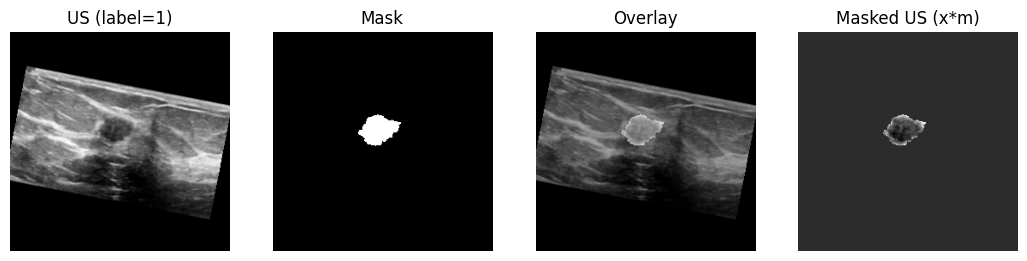

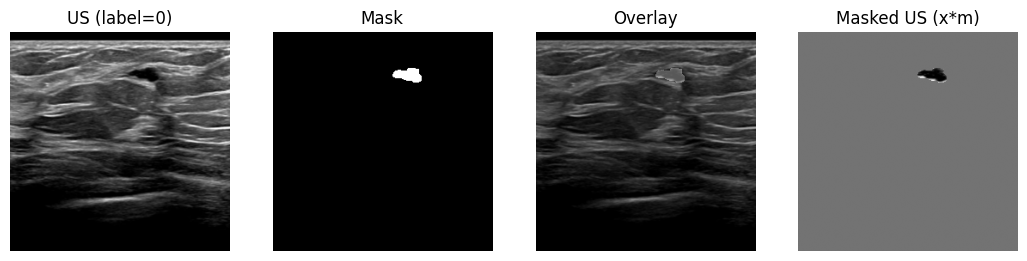

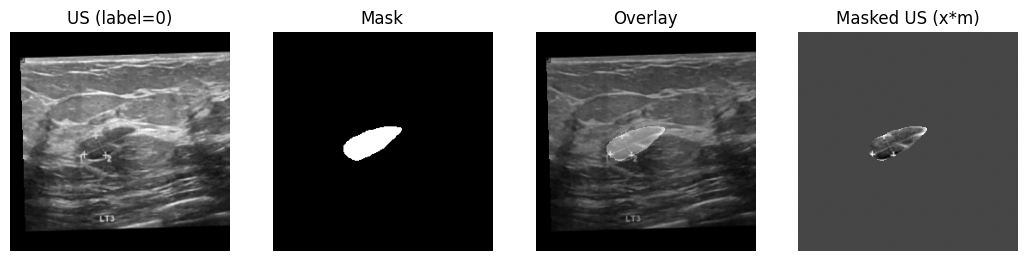

In [12]:

def show_augmented_seg_samples(ds, n=3):
    for i in range(n):
        x, m, y = ds[np.random.randint(0, len(ds))]
        fig, ax = plt.subplots(1, 4, figsize=(13, 3))
        ax[0].imshow(x[0].numpy(), cmap="gray")
        ax[0].set_title(f"US (label={y})")
        ax[0].axis("off")
        ax[1].imshow(m[0].numpy(), cmap="gray")
        ax[1].set_title("Mask")
        ax[1].axis("off")
        ax[2].imshow(x[0].numpy(), cmap="gray")
        ax[2].imshow(m[0].numpy(), alpha=0.35, cmap="gray")
        ax[2].set_title("Overlay")
        ax[2].axis("off")
        ax[3].imshow((x[0] * m[0]).numpy(), cmap="gray")
        ax[3].set_title("Masked US (x*m)")
        ax[3].axis("off")
        plt.show()

show_augmented_seg_samples(train_seg_ds, n=3)


In [13]:
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def confusion_matrix_3(y_true, y_pred, num_classes=3):
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    for t, p in zip(y_true, y_pred):
        cm[int(t), int(p)] += 1
    return cm

def macro_f1_from_cm(cm):
    # cm rows=true, cols=pred
    f1s = []
    for k in range(cm.shape[0]):
        tp = cm[k, k]
        fp = cm[:, k].sum() - tp
        fn = cm[k, :].sum() - tp
        prec = tp / (tp + fp + 1e-9)
        rec  = tp / (tp + fn + 1e-9)
        f1 = 2 * prec * rec / (prec + rec + 1e-9)
        f1s.append(f1)
    return float(np.mean(f1s))

def accuracy_from_cm(cm):
    return float(np.trace(cm) / (cm.sum() + 1e-9))

def balanced_accuracy_from_cm(cm):
    recalls = []
    for k in range(cm.shape[0]):
        tp = cm[k, k]
        fn = cm[k, :].sum() - tp
        rec = tp / (tp + fn + 1e-9)
        recalls.append(rec)
    return float(np.mean(recalls))



Device: cuda


In [14]:
import torchvision
from torchvision import models
from torch import nn
from torch.cuda.amp import autocast, GradScaler

def patch_first_conv_to_1ch(model):
    # EfficientNetV2: first conv is typically model.features[0][0]
    conv = None
    if hasattr(model, "features") and isinstance(model.features[0], nn.Sequential):
        if isinstance(model.features[0][0], nn.Conv2d):
            conv = model.features[0][0]
            where = ("features", 0, 0)
    if conv is None and hasattr(model, "conv1"):
        conv = model.conv1
        where = ("conv1",)

    assert conv is not None, "Could not locate first conv layer to patch."

    new_conv = nn.Conv2d(
        in_channels=1,
        out_channels=conv.out_channels,
        kernel_size=conv.kernel_size,
        stride=conv.stride,
        padding=conv.padding,
        bias=(conv.bias is not None)
    )

    # initialize from pretrained RGB weights by averaging over input channel dim
    with torch.no_grad():
        new_conv.weight.copy_(conv.weight.mean(dim=1, keepdim=True))
        if conv.bias is not None:
            new_conv.bias.copy_(conv.bias)

    # assign back
    if where[0] == "features":
        model.features[where[1]][where[2]] = new_conv
    else:
        model.conv1 = new_conv

    return model

def make_efficientnetv2_classifier(num_classes=3):
    weights = models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
    m = models.efficientnet_v2_s(weights=weights)
    m = patch_first_conv_to_1ch(m)
    m.classifier[1] = nn.Linear(m.classifier[1].in_features, num_classes)
    return m

def compute_class_weights(df):
    counts = df["LABEL"].value_counts().sort_index()
    freqs = counts / counts.sum()
    w = (1.0 / (freqs + 1e-9))
    w = w / w.mean()
    return torch.tensor(w.values, dtype=torch.float32)

@torch.no_grad()
def eval_classifier(model, loader):
    model.eval()
    y_true, y_pred = [], []
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        pred = logits.argmax(dim=1)
        y_true.extend(y.cpu().numpy().tolist())
        y_pred.extend(pred.cpu().numpy().tolist())
    cm = confusion_matrix_3(y_true, y_pred, 3)
    return {
        "cm": cm,
        "acc": accuracy_from_cm(cm),
        "macro_f1": macro_f1_from_cm(cm),
        "bal_acc": balanced_accuracy_from_cm(cm)
    }

def train_classifier(model, train_loader, val_loader, epochs=8, lr=3e-4, wd=1e-4):
    hist = {"train_loss": [], "val_acc": [], "val_macro_f1": []}
    model = model.to(device)
    class_w = compute_class_weights(train_loader.dataset.df).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_w)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
    scaler = GradScaler(enabled=(device.type=="cuda"))

    best_state, best_f1 = None, -1.0

    for ep in range(1, epochs+1):
        model.train()
        running = 0.0

        for x, y in train_loader:
            x = x.to(device); y = y.to(device)
            opt.zero_grad(set_to_none=True)

            with autocast(enabled=(device.type=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)

            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            running += loss.item() * x.size(0)

        sched.step()
        val = eval_classifier(model, val_loader)

        hist["train_loss"].append(running / len(train_loader.dataset))
        hist["val_acc"].append(val["acc"])
        hist["val_macro_f1"].append(val["macro_f1"])

        print(f"Epoch {ep:02d} | train_loss={running/len(train_loader.dataset):.4f} "
              f"| val_acc={val['acc']:.4f} | val_macroF1={val['macro_f1']:.4f}")

        if val["macro_f1"] > best_f1:
            best_f1 = val["macro_f1"]
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    model.load_state_dict(best_state)
    return model, hist

# Train 3-class classifier
clf3 = make_efficientnetv2_classifier(num_classes=3)
clf3, hist_clf3 = train_classifier(clf3, train_cls_loader, val_cls_loader, epochs=8, lr=3e-4)
val_metrics = eval_classifier(clf3, val_cls_loader)
print("VAL confusion matrix:\n", val_metrics["cm"])


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 143MB/s]
/tmp/ipython-input-4168712214.py:82: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type=="cuda"))
/tmp/ipython-input-4168712214.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type=="cuda")):


Epoch 01 | train_loss=0.8294 | val_acc=0.7268 | val_macroF1=0.7321
Epoch 02 | train_loss=0.4905 | val_acc=0.7760 | val_macroF1=0.7640
Epoch 03 | train_loss=0.3397 | val_acc=0.8033 | val_macroF1=0.7995
Epoch 04 | train_loss=0.2445 | val_acc=0.7978 | val_macroF1=0.8070
Epoch 05 | train_loss=0.1582 | val_acc=0.8415 | val_macroF1=0.8444
Epoch 06 | train_loss=0.0984 | val_acc=0.7978 | val_macroF1=0.8001
Epoch 07 | train_loss=0.0728 | val_acc=0.8251 | val_macroF1=0.8213
Epoch 08 | train_loss=0.0691 | val_acc=0.8306 | val_macroF1=0.8245
VAL confusion matrix:
 [[70 13  3]
 [10 39  1]
 [ 1  1 45]]


In [15]:
from torch.utils.data import DataLoader

# Colab-stable defaults
NW = 0
PIN = torch.cuda.is_available()

# Binary segmentation (lesion vs background)
train_df_bm = train_df[train_df["LABEL"].isin([0, 1])].reset_index(drop=True)
val_df_bm   = val_df[val_df["LABEL"].isin([0, 1])].reset_index(drop=True)
test_df_bm  = test_df[test_df["LABEL"].isin([0, 1])].reset_index(drop=True)

train_seg_ds = BreastUSDataset(train_df_bm, out_size=256, task="seg_binary", is_train=True,  augment=True)
val_seg_ds   = BreastUSDataset(val_df_bm,   out_size=256, task="seg_binary", is_train=False, augment=False)
test_seg_ds  = BreastUSDataset(test_df_bm,  out_size=256, task="seg_binary", is_train=False, augment=False)

# 3-class segmentation (0=bg, 1=benign lesion, 2=malignant lesion)
train_seg3_ds = BreastUSDataset(train_df, out_size=256, task="seg_3class", is_train=True,  augment=True)
val_seg3_ds   = BreastUSDataset(val_df,   out_size=256, task="seg_3class", is_train=False, augment=False)
test_seg3_ds  = BreastUSDataset(test_df,  out_size=256, task="seg_3class", is_train=False, augment=False)

print("Seg loaders ready.")


Seg loaders ready.


In [16]:
import numpy as np
import torch
from torch import nn
from torch.amp import autocast, GradScaler

# Define UNet only if not already defined
if "UNet" not in globals():
    class DoubleConv(nn.Module):
        def __init__(self, c_in, c_out):
            super().__init__()
            self.net = nn.Sequential(
                nn.Conv2d(c_in, c_out, 3, padding=1, bias=False),
                nn.BatchNorm2d(c_out),
                nn.ReLU(inplace=True),
                nn.Conv2d(c_out, c_out, 3, padding=1, bias=False),
                nn.BatchNorm2d(c_out),
                nn.ReLU(inplace=True),
            )
        def forward(self, x): return self.net(x)

    class UNet(nn.Module):
        def __init__(self, in_ch=1, out_ch=1, base=32):
            super().__init__()
            self.enc1 = DoubleConv(in_ch, base)
            self.enc2 = DoubleConv(base, base*2)
            self.enc3 = DoubleConv(base*2, base*4)
            self.enc4 = DoubleConv(base*4, base*8)
            self.pool = nn.MaxPool2d(2)
            self.mid  = DoubleConv(base*8, base*16)

            self.up4  = nn.ConvTranspose2d(base*16, base*8, 2, stride=2)
            self.dec4 = DoubleConv(base*16, base*8)
            self.up3  = nn.ConvTranspose2d(base*8, base*4, 2, stride=2)
            self.dec3 = DoubleConv(base*8, base*4)
            self.up2  = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
            self.dec2 = DoubleConv(base*4, base*2)
            self.up1  = nn.ConvTranspose2d(base*2, base, 2, stride=2)
            self.dec1 = DoubleConv(base*2, base)

            self.head = nn.Conv2d(base, out_ch, 1)

        def forward(self, x):
            e1 = self.enc1(x)
            e2 = self.enc2(self.pool(e1))
            e3 = self.enc3(self.pool(e2))
            e4 = self.enc4(self.pool(e3))
            m  = self.mid(self.pool(e4))

            d4 = self.up4(m); d4 = self.dec4(torch.cat([d4, e4], 1))
            d3 = self.up3(d4); d3 = self.dec3(torch.cat([d3, e3], 1))
            d2 = self.up2(d3); d2 = self.dec2(torch.cat([d2, e2], 1))
            d1 = self.up1(d2); d1 = self.dec1(torch.cat([d1, e1], 1))
            return self.head(d1)

# ---- Binary seg metrics/loss ----
def dice_from_logits_bin(logits, target, eps=1e-6):
    # logits [B,1,H,W], target [B,1,H,W] in {0,1}
    p = (torch.sigmoid(logits) > 0.5).float()
    inter = (p*target).sum((1,2,3))
    union = p.sum((1,2,3)) + target.sum((1,2,3))
    return ((2*inter + eps) / (union + eps)).mean().item()

def iou_from_logits_bin(logits, target, eps=1e-6):
    p = (torch.sigmoid(logits) > 0.5).float()
    inter = (p*target).sum((1,2,3))
    union = p.sum((1,2,3)) + target.sum((1,2,3)) - inter
    return ((inter + eps) / (union + eps)).mean().item()

def dice_loss_bin(logits, target, eps=1e-6):
    p = torch.sigmoid(logits)
    inter = (p*target).sum((1,2,3))
    union = p.sum((1,2,3)) + target.sum((1,2,3))
    dice = (2*inter + eps) / (union + eps)
    return 1 - dice.mean()

@torch.no_grad()
def eval_seg_binary(model, loader):
    model.eval()
    ds, js = [], []
    for x, m, _ in loader:
        x = x.to(device); m = m.to(device)
        logits = model(x)
        ds.append(dice_from_logits_bin(logits, m))
        js.append(iou_from_logits_bin(logits, m))
    return float(np.mean(ds)), float(np.mean(js))

def train_seg_binary(model, train_loader, val_loader, epochs=10, lr=3e-4):
    model = model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
    scaler = GradScaler("cuda") if device.type=="cuda" else None
    bce = nn.BCEWithLogitsLoss()

    best_state, best_dice = None, -1.0
    hist = {"train_loss": [], "val_dice": [], "val_iou": []}

    for ep in range(1, epochs+1):
        model.train()
        run = 0.0
        for x, m, _ in train_loader:
            x = x.to(device, non_blocking=True)
            m = m.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)

            if device.type=="cuda":
                with autocast("cuda"):
                    logits = model(x)
                    loss = 0.5*bce(logits, m) + 0.5*dice_loss_bin(logits, m)
                scaler.scale(loss).backward()
                scaler.step(opt); scaler.update()
            else:
                logits = model(x)
                loss = 0.5*bce(logits, m) + 0.5*dice_loss_bin(logits, m)
                loss.backward(); opt.step()

            run += loss.item()*x.size(0)

        sched.step()
        vd, vj = eval_seg_binary(model, val_loader)
        hist["train_loss"].append(run / len(train_loader.dataset))
        hist["val_dice"].append(vd)
        hist["val_iou"].append(vj)

        print(f"[BinSeg] Ep{ep:02d} train_loss={run/len(train_loader.dataset):.4f} | val_dice={vd:.4f} val_iou={vj:.4f}")

        if vd > best_dice:
            best_dice = vd
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}

    model.load_state_dict(best_state)
    return model, hist

# ---- 3-class seg metrics/training ----
def dice_multiclass(logits, target_long, classes=(1,2), eps=1e-6):
    # logits [B,C,H,W], target [B,H,W]
    pred = logits.argmax(1)
    dices = []
    for c in classes:
        p = (pred == c).float()
        t = (target_long == c).float()
        inter = (p*t).sum((1,2))
        union = p.sum((1,2)) + t.sum((1,2))
        dices.append(((2*inter+eps)/(union+eps)).mean())
    return torch.stack(dices).mean().item()

@torch.no_grad()
def eval_seg3(model, loader):
    model.eval()
    ds = []
    for x, m3, _ in loader:
        x = x.to(device); m3 = m3.to(device)
        logits = model(x)
        ds.append(dice_multiclass(logits, m3, classes=(1,2)))
    return float(np.mean(ds))

#Improve segmnetation trial 1
def compute_pixel_class_weights_seg3(loader, num_classes=3):
    # counts pixels per class over (a subset of) the training data
    counts = torch.zeros(num_classes, dtype=torch.float64)
    for i, (_, m3, _) in enumerate(loader):
        # m3: [B,H,W] long
        for c in range(num_classes):
            counts[c] += (m3 == c).sum().item()
        # optional speed cap: stop after ~50 batches
        if i >= 50:
            break
    freqs = counts / counts.sum()
    w = 1.0 / (freqs + 1e-12)
    w = w / w.mean()
    return w.float()

#Imrpove segmentation trial 2
def soft_dice_loss_multiclass(logits, target_long, classes=(1,2), eps=1e-6):
    # logits: [B,C,H,W], target_long: [B,H,W]
    probs = torch.softmax(logits, dim=1)
    loss = 0.0
    for c in classes:
        p = probs[:, c, :, :]
        t = (target_long == c).float()
        inter = (p * t).sum((1,2))
        union = p.sum((1,2)) + t.sum((1,2))
        dice = (2*inter + eps) / (union + eps)
        loss += (1 - dice).mean()
    return loss / len(classes)


def train_seg3(model, train_loader, val_loader, epochs=10, lr=3e-4):
    model = model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
    scaler = GradScaler("cuda") if device.type=="cuda" else None
    w = compute_pixel_class_weights_seg3(train_loader, num_classes=3).to(device)
    print("Seg3 pixel class weights:", w.detach().cpu().numpy())
    ce = nn.CrossEntropyLoss() #removed weight=w in CrossEntropyLoss() since it collapsed the model

    best_state, best_dice = None, -1.0
    hist = {"train_loss": [], "val_lesionDice": []}

    for ep in range(1, epochs+1):
        model.train()
        run = 0.0
        for x, m3, _ in train_loader:
            x = x.to(device, non_blocking=True)
            m3 = m3.to(device, non_blocking=True)  # [B,H,W] long
            opt.zero_grad(set_to_none=True)

            if device.type=="cuda":
                with autocast("cuda"):
                  logits = model(x)     # [B,3,H,W]
                  loss = ce(logits, m3)
                  scaler.scale(loss).backward()
                  scaler.step(opt); scaler.update()
            else:
                logits = model(x)
                loss = ce(logits, m3)
                loss.backward(); opt.step()

            run += loss.item()*x.size(0)

        sched.step()
        vd = eval_seg3(model, val_loader)
        hist["train_loss"].append(run / len(train_loader.dataset))
        hist["val_lesionDice"].append(vd)
        print(f"[Seg3]  Ep{ep:02d} train_loss={run/len(train_loader.dataset):.4f} | val_lesionDice={vd:.4f}")

        if vd > best_dice:
            best_dice = vd
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}

    model.load_state_dict(best_state)
    return model, hist


In [17]:
# 1) Binary segmenter (lesion vs background)
seg_bin = UNet(in_ch=1, out_ch=1, base=32)
seg_bin, hist_seg_bin = train_seg_binary(seg_bin, train_seg_loader, val_seg_loader, epochs=10, lr=3e-4)

val_dice, val_iou = eval_seg_binary(seg_bin, val_seg_loader)
test_dice, test_iou = eval_seg_binary(seg_bin, test_seg_loader)
print("\n[BinSeg] FINAL  val_dice={:.4f} val_iou={:.4f} | test_dice={:.4f} test_iou={:.4f}"
      .format(val_dice, val_iou, test_dice, test_iou))

# 2) 3-class segmenter (bg/benign/malignant)
seg3 = UNet(in_ch=1, out_ch=3, base=32)
seg3, hist_seg3 = train_seg3(seg3, train_seg3_loader, val_seg3_loader, epochs=10, lr=3e-4)

val_d = eval_seg3(seg3, val_seg3_loader)
test_d = eval_seg3(seg3, test_seg3_loader)
print("\n[Seg3]  FINAL  val_lesionDice={:.4f} | test_lesionDice={:.4f}".format(val_d, test_d))


[BinSeg] Ep01 train_loss=0.6856 | val_dice=0.2940 val_iou=0.1908
[BinSeg] Ep02 train_loss=0.5911 | val_dice=0.4246 val_iou=0.3052
[BinSeg] Ep03 train_loss=0.5476 | val_dice=0.4831 val_iou=0.3588
[BinSeg] Ep04 train_loss=0.5152 | val_dice=0.5985 val_iou=0.4751
[BinSeg] Ep05 train_loss=0.4897 | val_dice=0.5754 val_iou=0.4451
[BinSeg] Ep06 train_loss=0.4708 | val_dice=0.5984 val_iou=0.4784
[BinSeg] Ep07 train_loss=0.4509 | val_dice=0.6445 val_iou=0.5315
[BinSeg] Ep08 train_loss=0.4403 | val_dice=0.6441 val_iou=0.5257
[BinSeg] Ep09 train_loss=0.4327 | val_dice=0.6620 val_iou=0.5454
[BinSeg] Ep10 train_loss=0.4299 | val_dice=0.6619 val_iou=0.5454

[BinSeg] FINAL  val_dice=0.6620 val_iou=0.5454 | test_dice=0.6230 test_iou=0.5007
Seg3 pixel class weights: [0.0329277 1.3800608 1.5870115]
[Seg3]  Ep01 train_loss=0.4406 | val_lesionDice=0.5148
[Seg3]  Ep02 train_loss=0.2435 | val_lesionDice=0.3878
[Seg3]  Ep03 train_loss=0.1828 | val_lesionDice=0.5901
[Seg3]  Ep04 train_loss=0.1587 | val_lesionD

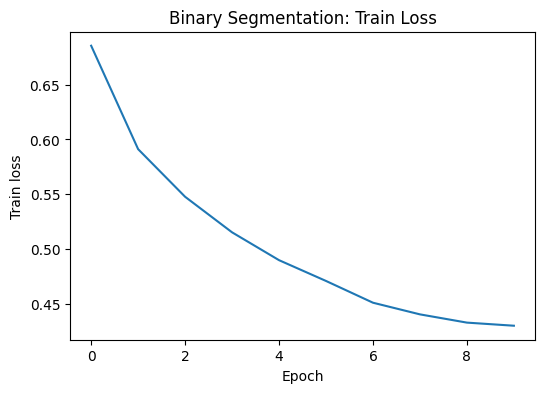

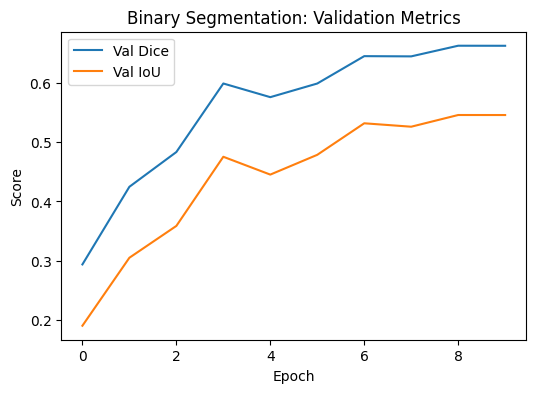

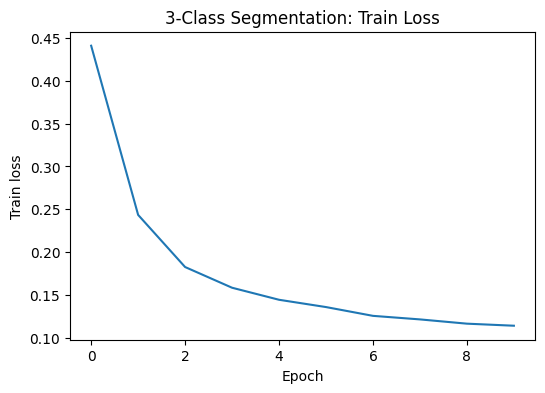

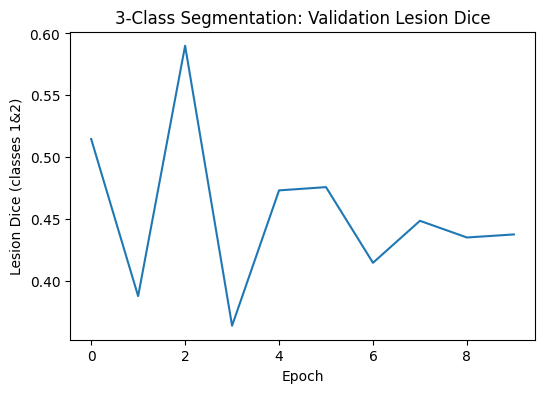

In [18]:
# Plotting of Segmentation Results (binary and 3-class)
import matplotlib.pyplot as plt

def plot_binseg_history(hist):
    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(hist["train_loss"])
    plt.xlabel("Epoch")
    plt.ylabel("Train loss")
    plt.title("Binary Segmentation: Train Loss")
    plt.show()

    # Dice & IoU
    plt.figure(figsize=(6,4))
    plt.plot(hist["val_dice"], label="Val Dice")
    plt.plot(hist["val_iou"], label="Val IoU")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Binary Segmentation: Validation Metrics")
    plt.legend()
    plt.show()

plot_binseg_history(hist_seg_bin)

def plot_seg3_history(hist):
    plt.figure(figsize=(6,4))
    plt.plot(hist["train_loss"])
    plt.xlabel("Epoch")
    plt.ylabel("Train loss")
    plt.title("3-Class Segmentation: Train Loss")
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(hist["val_lesionDice"])
    plt.xlabel("Epoch")
    plt.ylabel("Lesion Dice (classes 1&2)")
    plt.title("3-Class Segmentation: Validation Lesion Dice")
    plt.show()

plot_seg3_history(hist_seg3)


In [19]:
import torch.nn.functional as F
from torch.utils.data import Dataset

def crop_roi_from_mask(x, mask, margin=10):
    # x: [1,256,256], mask: [1,256,256] in {0,1}
    m = (mask[0] > 0.5)
    if m.sum() == 0:
        return x  # fallback
    ys, xs = torch.where(m)
    y0, y1 = ys.min().item(), ys.max().item()
    x0, x1 = xs.min().item(), xs.max().item()
    y0 = max(0, y0-margin); y1 = min(255, y1+margin)
    x0 = max(0, x0-margin); x1 = min(255, x1+margin)

    crop = x[:, y0:y1+1, x0:x1+1]            # [1,h,w]
    crop_m = mask[:, y0:y1+1, x0:x1+1]
    crop = crop * crop_m

    # pad to square then resize back to 256
    _, h, w = crop.shape
    side = max(h, w)
    pad_h, pad_w = side-h, side-w
    crop = F.pad(crop, (pad_w//2, pad_w-pad_w//2, pad_h//2, pad_h-pad_h//2), value=0.0)
    crop = F.interpolate(crop.unsqueeze(0), size=(256,256), mode="bilinear", align_corners=False).squeeze(0)
    return crop

class BMROICLFDataset(Dataset):
    """
    Trains B/M classifier using GT masks (labels 0/1 only).
    """
    def __init__(self, df, is_train=False, augment=False):
        self.df = df[df["LABEL"].isin([0,1])].reset_index(drop=True)
        self.base = BreastUSDataset(self.df, out_size=256, task="seg_binary", is_train=is_train, augment=augment)

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        x, m, y = self.base[idx]        # y in {0,1}
        x_roi = crop_roi_from_mask(x, m, margin=10)
        y_bin = 0 if y==0 else 1
        return x_roi, y_bin

# Loaders
bm_train_ds = BMROICLFDataset(train_df, is_train=True,  augment=True)
bm_val_ds   = BMROICLFDataset(val_df,   is_train=False, augment=False)
bm_test_ds  = BMROICLFDataset(test_df,  is_train=False, augment=False)

bm_train_loader = DataLoader(bm_train_ds, batch_size=32, shuffle=True,  num_workers=NW, pin_memory=PIN)
bm_val_loader   = DataLoader(bm_val_ds,   batch_size=64, shuffle=False, num_workers=NW, pin_memory=PIN)
bm_test_loader  = DataLoader(bm_test_ds,  batch_size=64, shuffle=False, num_workers=NW, pin_memory=PIN)

# Binary EfficientNet (2 classes)
clf_bm = make_efficientnetv2_classifier(num_classes=2)

from torch.amp import autocast, GradScaler
def train_bm(model, train_loader, val_loader, epochs=6, lr=3e-4):
    model = model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
    crit = nn.CrossEntropyLoss()
    scaler = GradScaler("cuda") if device.type=="cuda" else None

    @torch.no_grad()
    def eval_acc(loader):
        model.eval()
        ys, ps = [], []
        for x, y in loader:
            x = x.to(device); y = y.to(device)
            logits = model(x)
            ps.extend(logits.argmax(1).cpu().numpy().tolist())
            ys.extend(y.cpu().numpy().tolist())
        return float(np.mean(np.array(ps)==np.array(ys)))

    best_state, best_acc = None, -1.0
    for ep in range(1, epochs+1):
        model.train()
        for x, y in train_loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            if device.type=="cuda":
                with autocast("cuda"):
                    loss = crit(model(x), y)
                scaler.scale(loss).backward()
                scaler.step(opt); scaler.update()
            else:
                loss = crit(model(x), y)
                loss.backward(); opt.step()
        sched.step()
        va = eval_acc(val_loader)
        print(f"[BM-ROI] Ep{ep:02d} val_acc={va:.4f}")
        if va > best_acc:
            best_acc = va
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}

    model.load_state_dict(best_state)
    return model

clf_bm = train_bm(clf_bm, bm_train_loader, bm_val_loader, epochs=6, lr=3e-4)


[BM-ROI] Ep01 val_acc=0.7500
[BM-ROI] Ep02 val_acc=0.7941
[BM-ROI] Ep03 val_acc=0.8750
[BM-ROI] Ep04 val_acc=0.8676
[BM-ROI] Ep05 val_acc=0.8676
[BM-ROI] Ep06 val_acc=0.8971


In [20]:
@torch.no_grad()
def eval_seg_first_3class(seg3_model, bm_model, df_eval, area_thresh=0.002):
    """
    Returns 3-class confusion matrix for labels:
      0=Benign, 1=Malignant, 2=Normal
    """
    seg3_model.eval(); bm_model.eval()

    tmp = BreastUSDataset(df_eval, out_size=256, task="seg_3class", is_train=False, augment=False)
    loader = DataLoader(tmp, batch_size=16, shuffle=False, num_workers=NW, pin_memory=PIN)

    y_true, y_pred = [], []

    for x, m3_true, y in loader:
        x = x.to(device)
        logits = seg3_model(x)              # [B,3,H,W]
        pred_pix = logits.argmax(1)         # [B,H,W]

        lesion = (pred_pix == 1) | (pred_pix == 2)
        lesion_area = lesion.float().mean((1,2))  # fraction of pixels

        pred_label = torch.full((x.size(0),), 2, device=device, dtype=torch.long)  # default Normal

        idx = torch.where(lesion_area >= area_thresh)[0]
        if len(idx) > 0:
            x_sel = x[idx]
            m_sel = lesion[idx].float().unsqueeze(1)  # [k,1,H,W]

            rois = torch.stack([crop_roi_from_mask(x_sel[i], m_sel[i], margin=10)
                                for i in range(len(idx))], dim=0)
            bm_logits = bm_model(rois)
            bm_pred = bm_logits.argmax(1)  # 0=Benign, 1=Malignant
            pred_label[idx] = bm_pred

        y_true.extend(y.numpy().tolist())
        y_pred.extend(pred_label.cpu().numpy().tolist())

    cm = confusion_matrix_3(y_true, y_pred, 3)
    return {"cm": cm, "acc": accuracy_from_cm(cm), "macro_f1": macro_f1_from_cm(cm)}

def tune_area_thresh(seg3_model, bm_model, df_val):
    # small grid; you can widen if needed
    grid = np.linspace(0.0005, 0.01, 15)
    best = None
    for t in grid:
        m = eval_seg_first_3class(seg3_model, bm_model, df_val, area_thresh=float(t))
        if best is None or m["macro_f1"] > best["macro_f1"]:
            best = {**m, "thresh": float(t)}
    return best

best_gate = tune_area_thresh(seg3, clf_bm, val_df)
print("[Seg→Cls] Best area_thresh on VAL:", best_gate["thresh"])
print("[Seg→Cls] VAL acc/macroF1:", best_gate["acc"], best_gate["macro_f1"])
print("[Seg→Cls] VAL CM:\n", best_gate["cm"])


[Seg→Cls] Best area_thresh on VAL: 0.0005
[Seg→Cls] VAL acc/macroF1: 0.5628415300515692 0.49031611923512664
[Seg→Cls] VAL CM:
 [[52  2 32]
 [30  6 14]
 [ 1  1 45]]


In [21]:
import pandas as pd

# Direct classifier evaluation on val/test (uses your clf3 + datasets)
val_cls_ds = BreastUSDataset(val_df, out_size=256, task="classification", is_train=False, augment=False)
test_cls_ds = BreastUSDataset(test_df, out_size=256, task="classification", is_train=False, augment=False)

val_cls_loader = DataLoader(val_cls_ds, batch_size=64, shuffle=False, num_workers=NW, pin_memory=PIN)
test_cls_loader = DataLoader(test_cls_ds, batch_size=64, shuffle=False, num_workers=NW, pin_memory=PIN)

direct_val = eval_classifier(clf3, val_cls_loader)
direct_test = eval_classifier(clf3, test_cls_loader)

segfirst_val = eval_seg_first_3class(seg3, clf_bm, val_df, area_thresh=best_gate["thresh"])
segfirst_test = eval_seg_first_3class(seg3, clf_bm, test_df, area_thresh=best_gate["thresh"])

print("\n=== CONFUSION MATRICES (rows=true, cols=pred; classes 0=B,1=M,2=N) ===")
print("\n[Direct Classifier] VAL CM:\n", direct_val["cm"])
print("\n[Seg→Cls Pipeline] VAL CM:\n", segfirst_val["cm"])
print("\n[Direct Classifier] TEST CM:\n", direct_test["cm"])
print("\n[Seg→Cls Pipeline] TEST CM:\n", segfirst_test["cm"])

summary = pd.DataFrame([
    {"Pipeline":"Direct 3-class classifier", "Split":"VAL",  "Acc":direct_val["acc"],  "MacroF1":direct_val["macro_f1"]},
    {"Pipeline":"Seg→Cls (3-class output)",  "Split":"VAL",  "Acc":segfirst_val["acc"],"MacroF1":segfirst_val["macro_f1"]},
    {"Pipeline":"Direct 3-class classifier", "Split":"TEST", "Acc":direct_test["acc"], "MacroF1":direct_test["macro_f1"]},
    {"Pipeline":"Seg→Cls (3-class output)",  "Split":"TEST", "Acc":segfirst_test["acc"],"MacroF1":segfirst_test["macro_f1"]},
])

print("\n=== SUMMARY (higher is better) ===")
print(summary.to_string(index=False))



=== CONFUSION MATRICES (rows=true, cols=pred; classes 0=B,1=M,2=N) ===

[Direct Classifier] VAL CM:
 [[70 13  3]
 [10 39  1]
 [ 1  1 45]]

[Seg→Cls Pipeline] VAL CM:
 [[52  2 32]
 [30  6 14]
 [ 1  1 45]]

[Direct Classifier] TEST CM:
 [[78  8  1]
 [ 7 49  7]
 [ 0  6 56]]

[Seg→Cls Pipeline] TEST CM:
 [[43  2 42]
 [41  6 16]
 [ 6  1 55]]

=== SUMMARY (higher is better) ===
                 Pipeline Split      Acc  MacroF1
Direct 3-class classifier   VAL 0.841530 0.844368
 Seg→Cls (3-class output)   VAL 0.562842 0.490316
Direct 3-class classifier  TEST 0.863208 0.857881
 Seg→Cls (3-class output)  TEST 0.490566 0.427038
